Intentar ver si existealguna relacion entre las empresas que se adjudican las licitaciones y los valores que tiene cada licitacion.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import math

plt.style.use('ggplot')
plt.rcParams['font.size'] = 20.0
plt.rcParams['axes.labelsize'] = 20.0
plt.rcParams['xtick.labelsize'] = 20.0
plt.rcParams['ytick.labelsize'] = 20.0
plt.rcParams['legend.fontsize'] = 20.0

%matplotlib inline

# set the max column width
pd.options.display.max_colwidth = 1000

In [2]:
def normalize_col(col):
    if not np.issubdtype(col.dtype, np.number):
        return col
    return (col - col.min()) / (col.max() - col.min())


def filter_and_normalize(dataset):
    # Remove invariante data
    for col in dataset.columns:
        if dataset[col].unique().shape[0] == 1:
            dataset.drop(col, axis=1, inplace=True)
            
    # Normalize Data
    dataset_norm = dataset.apply(normalize_col, axis=0)
    
    # Encode non numerical
    from sklearn import preprocessing
    le_dict = dict()
    for col in dataset_norm.columns:
        if np.issubdtype(dataset_norm[col].dtype, np.number):
            continue
        # take care of nan values
        dataset_norm[col].fillna(value=str(np.nan), inplace=True)
        le = preprocessing.LabelEncoder()
        # fit the labels
        _ = le.fit(dataset_norm[col])
        # transform the labels
        dataset_norm[col] = le.transform(dataset_norm[col])
    #    print(le.inverse_transform(dataset[col]))
        # save the labeler
        le_dict[col] = le
        
    return dataset_norm

In [3]:
pd.options.mode.chained_assignment = None
import matplotlib
import matplotlib.ticker as mtick
matplotlib.style.use('ggplot')

In [4]:
base_dir = '.'
data_dir = base_dir + os.sep + 'dataNov2016' + os.sep

In [5]:
os.listdir('./dataNov2016/')

['tenderIdList.csv', 'tenderProduct.csv', 'tender.csv']

In [6]:
tender_df = pd.read_csv(data_dir + 'tender.csv')
tprod_df = pd.read_csv(data_dir + 'tenderProduct.csv')
tenderid_df = pd.read_csv(data_dir + 'tenderIdList.csv')

In [7]:
print('tender shape: ', tender_df.shape)
print('product shape: ', tprod_df.shape)
print('tender id shape: ', tenderid_df.shape)

tender shape:  (17165, 84)
product shape:  (74799, 13)
tender id shape:  (17164, 1)


In [8]:
print(tprod_df.columns)
tprod_df.head(1)

Index(['AdjudicacionCantidad', 'AdjudicacionMontoUnitario',
       'AdjudicacionNombreProveedor', 'AdjudicacionRutProveedor', 'Cantidad',
       'Categoria', 'CodigoCategoria', 'CodigoExterno', 'CodigoProducto',
       'Correlativo', 'Descripcion', 'NombreProducto', 'UnidadMedida'],
      dtype='object')


,AdjudicacionCantidad,AdjudicacionMontoUnitario,AdjudicacionNombreProveedor,AdjudicacionRutProveedor,Cantidad,Categoria,CodigoCategoria,CodigoExterno,CodigoProducto,Correlativo,Descripcion,NombreProducto,UnidadMedida
0,6000.0,5490.0,Sociedad de Aridos y Asfaltos Serviterra Ltda,76.400.247-4,6000.0,Productos derivados de minerales plantas y animales / Tierra y piedra / Piedras,11111600,1000-49-LE16,11111611,1,ADQUISICION DE SUMINISTRO MATERIAL PETREO PARA ACOPIO EN RECINTO FISCAL EL AVELLANO COMUNA DE LOS ANGELES PROVINCIA DEL BIOBIO DE LA DIRECCION DE VIALIDAD REGION DEL BIOBIO,Grava,Metro Cubico


In [9]:
print(tender_df.columns)

Index(['AdjudicacionFecha', 'AdjudicacionNumero',
       'AdjudicacionNumeroOferentes', 'AdjudicacionTipo',
       'AdjudicacionUrlActa', 'CantidadReclamos', 'CodigoEstado',
       'CodigoExterno', 'CodigoTipo', 'CompradorCargoUsuario',
       'CompradorCodigoOrganismo', 'CompradorCodigoUnidad',
       'CompradorCodigoUsuario', 'CompradorComunaUnidad',
       'CompradorDireccionUnidad', 'CompradorNombreOrganismo',
       'CompradorNombreUnidad', 'CompradorNombreUsuario',
       'CompradorRegionUnidad', 'CompradorRutUnidad', 'CompradorRutUsuario',
       'Contrato', 'Descripcion', 'DiasCierreLicitacion', 'DireccionEntrega',
       'DireccionVisita', 'EmailResponsableContrato', 'EmailResponsablePago',
       'EsBaseTipo', 'EsRenovable', 'Estado', 'EstadoEtapas',
       'EstadoPublicidadOfertas', 'Estimacion', 'Etapas', 'ExtensionPlazo',
       'FechaCierre', 'FechasFechaActoAperturaEconomica',
       'FechasFechaActoAperturaTecnica', 'FechasFechaAdjudicacion',
       'FechasFechaCierre',

In [10]:
# Crear dict de codigo a lista de numero en tprod

dicCodigoExterno = {}
cod_externo_tender = tender_df['CodigoExterno'].tolist()
cod_externo_prod = tprod_df['CodigoExterno'].tolist()

for cod in cod_externo_tender:
    list_index = [i for i, j in enumerate(cod_externo_prod) if j == cod]
    dicCodigoExterno[cod] = list_index  

In [11]:
## Obtener las empresas que mas licitaciones ganan

# Sacar todas las licitaciones que no fueron adjudicadas
tender_adj = tender_df[tender_df['AdjudicacionFecha'].notnull()]

# Agregar empresas como columnas
cols = ['AdjudicacionNombreProveedor', 'AdjudicacionRutProveedor']

cod_externo_tender_serie = tender_adj['CodigoExterno']
for col in cols:
    serie = cod_externo_tender_serie.apply(lambda cod: tprod_df.iloc[dicCodigoExterno[cod][0]][col])
    tender_adj[col] = serie

# tender_adj.columns



In [12]:
tender_adj_group = tender_adj[['CodigoExterno', 'AdjudicacionNombreProveedor']].groupby(by='AdjudicacionNombreProveedor')
tender_adj_group_sort = tender_adj_group.agg(['count']).sort_values([('CodigoExterno', 'count')], ascending=[False])

In [13]:
# filter all that only have one or two
licitaciones_empresas = tender_adj_group_sort[tender_adj_group_sort[('CodigoExterno', 'count')]>=38]
print(tender_adj_group_sort.shape)
print(licitaciones_empresas.shape)
licitaciones_empresas.head(11)
# licitaciones_empresas.tail(10)

(5999, 1)
(11, 1)


,CodigoExterno
,count
AdjudicacionNombreProveedor,
FARMACEUTICA CARIBEAN LTDA,89
EDUARDO AWAD MANZUR,79
LABORATORIO CHILE S A,68
DROGUERIA GLOBAL PHARMA SPA,67
IMPORTADORA Y DISTRIBUIDORA ARQUIMED LTDA,61
ROCHE CHILE LIMITADA,59
LABORATORIOS RECALCINE SA,57
KRISH CHILE IMPORTACIONES LIMITADA,53


In [14]:
# Get licitaciones from empresas that have > 10

empresas_name = [licitaciones_empresas.iloc[i].name for i in range(licitaciones_empresas.shape[0]) ]
tender_adj.head(6)

tender_top_empresas = tender_adj[tender_adj['AdjudicacionNombreProveedor'].isin( empresas_name)]
tender_top_empresas.shape
np.unique(np.array(tender_top_empresas['AdjudicacionNombreProveedor'].tolist())).shape

# empresa = licitaciones_empresas.iloc[0].name
# cantidad = licitaciones_empresas.iloc[0][('CodigoExterno', 'count')]
# print('empresa ', empresa, 'cantidad ', cantidad )
# tender_empresa = tender_adj[tender_adj['AdjudicacionNombreProveedor'] == empresa]

# licitaciones_empresas.plot.bar(figsize=(10, 8));
# plt.show()

(11,)

In [15]:
tender_top_empresas.columns

Index(['AdjudicacionFecha', 'AdjudicacionNumero',
       'AdjudicacionNumeroOferentes', 'AdjudicacionTipo',
       'AdjudicacionUrlActa', 'CantidadReclamos', 'CodigoEstado',
       'CodigoExterno', 'CodigoTipo', 'CompradorCargoUsuario',
       'CompradorCodigoOrganismo', 'CompradorCodigoUnidad',
       'CompradorCodigoUsuario', 'CompradorComunaUnidad',
       'CompradorDireccionUnidad', 'CompradorNombreOrganismo',
       'CompradorNombreUnidad', 'CompradorNombreUsuario',
       'CompradorRegionUnidad', 'CompradorRutUnidad', 'CompradorRutUsuario',
       'Contrato', 'Descripcion', 'DiasCierreLicitacion', 'DireccionEntrega',
       'DireccionVisita', 'EmailResponsableContrato', 'EmailResponsablePago',
       'EsBaseTipo', 'EsRenovable', 'Estado', 'EstadoEtapas',
       'EstadoPublicidadOfertas', 'Estimacion', 'Etapas', 'ExtensionPlazo',
       'FechaCierre', 'FechasFechaActoAperturaEconomica',
       'FechasFechaActoAperturaTecnica', 'FechasFechaAdjudicacion',
       'FechasFechaCierre',

In [16]:
cols_filter = ['AdjudicacionFecha', 'AdjudicacionNumeroOferentes', 'AdjudicacionTipo', 
               'CantidadReclamos', 'CompradorCodigoOrganismo', 'CompradorCodigoUnidad', 
               'FechasFechaCierre', 'FechasFechaPublicacion','FechasFechaEstimadaAdjudicacion', 'Modalidad', 'SubContratacion',
              'Tipo', 'TipoPago', 'VisibilidadMonto', 'AdjudicacionNombreProveedor' ]

tender_empresa_filter = tender_top_empresas[cols_filter]

In [17]:
date_colnames = filter(lambda colname: 'Fecha' in colname, tender_empresa_filter.columns)
for colname in date_colnames:
    tender_empresa_filter[colname] = pd.to_datetime(tender_empresa_filter[colname])

tender_empresa_filter['time_duration_days'] = (tender_empresa_filter['FechasFechaCierre'] - tender_empresa_filter['FechasFechaPublicacion']) / np.timedelta64(1, 'D')
tender_empresa_filter['time_estimated_days'] = (tender_empresa_filter['FechasFechaEstimadaAdjudicacion'] - tender_empresa_filter['FechasFechaPublicacion']) / np.timedelta64(1, 'D')


In [18]:
# remove all date features
non_date_cols = list(filter(lambda colname: 'Fecha' not in colname, tender_empresa_filter.columns))
tender_empresa_filter = tender_empresa_filter[non_date_cols]

tender_empresa_filter.head(5)

,AdjudicacionNumeroOferentes,AdjudicacionTipo,CantidadReclamos,CompradorCodigoOrganismo,CompradorCodigoUnidad,Modalidad,SubContratacion,Tipo,TipoPago,VisibilidadMonto,AdjudicacionNombreProveedor,time_duration_days,time_estimated_days
142,19.0,2.0,101,6924,2088,1,1,L1,4,1,FARMACEUTICA CARIBEAN LTDA,6.329710,15.967210
242,4.0,2.0,62,7102,2171,1,0,LE,4,0,IMPORTADORA Y DISTRIBUIDORA ARQUIMED LTDA,11.968461,54.010127
248,1.0,2.0,62,7102,2171,7,1,LE,4,1,B BRAUN MEDICAL SPA,11.983333,96.993750
273,1.0,2.0,115,7216,2189,1,0,L1,2,0,ROCHE CHILE LIMITADA,5.738012,7.072040
342,5.0,2.0,197,7029,2284,1,0,LE,1,0,DROGUERIA GLOBAL PHARMA SPA,7.290084,31.206750


In [19]:
tender_empresa_filter = filter_and_normalize(tender_empresa_filter)

tender_empresa_filter.head(1)

,AdjudicacionNumeroOferentes,AdjudicacionTipo,CantidadReclamos,CompradorCodigoOrganismo,CompradorCodigoUnidad,Modalidad,SubContratacion,Tipo,TipoPago,VisibilidadMonto,AdjudicacionNombreProveedor,time_duration_days,time_estimated_days
142,0.305085,0.2,0.030827,0.000004,0.000877,0.0,1.0,1,1.0,1.0,3,0.036509,0.036429


In [20]:
# var_threshold = .01
# for col in tender_empresa_filter.columns:
#     if tender_empresa_filter[col].var() < var_threshold:
#         tender_empresa_filter.drop(col, axis=1, inplace=True)
# tender_empresa_filter.columns

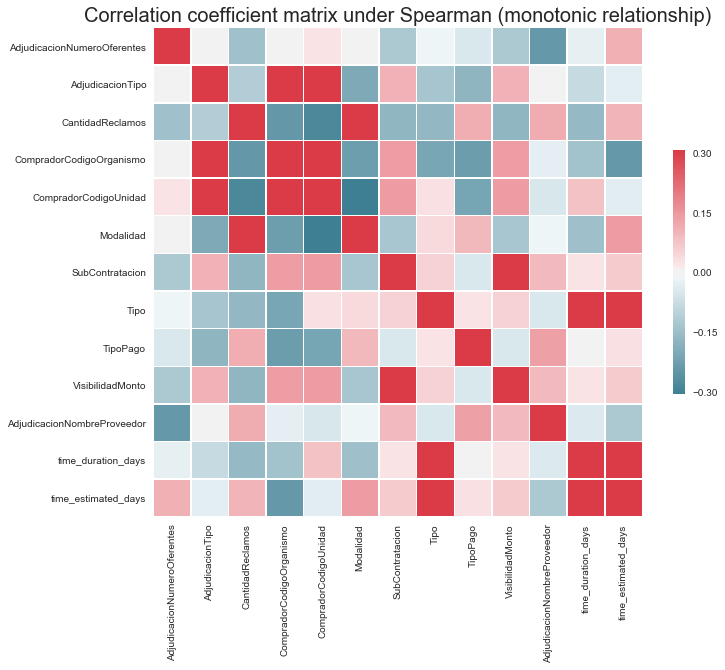

In [21]:
import seaborn as sns

corr = tender_empresa_filter.corr('spearman')

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

_ = ax.set_title('Correlation coefficient matrix under Spearman (monotonic relationship)', fontsize=20)

In [22]:
from neuron_network import NeuronNetwork

network = NeuronNetwork(tender_empresa_filter.shape[1]-1, 0.5)
network.add_layer(tender_empresa_filter.shape[1]-1)
network.add_layer(licitaciones_empresas.shape[0])


In [24]:
expectec_1d = np.array(tender_empresa_filter['AdjudicacionNombreProveedor'].tolist())

cols =tender_empresa_filter.columns.tolist()
cols.remove('AdjudicacionNombreProveedor')

matrix = np.transpose(np.array([tender_empresa_filter[col].tolist() for col in cols]))
# print(matrix[0][:])
# print(cols)
for epoch in range(4000):
    if epoch % 100 == 0:
        print(epoch)
    for tr in range(tender_empresa_filter.shape[0]):
        
        expected = np.zeros(143)
        expected[expectec_1d[tr]] = 1.0
        
        inputs = matrix[tr][:]
        output = network.feed(inputs)
        network.backpropagate_error(expected)
        network.update_weights()
        
        
        


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900


In [30]:
test = 200
print(expectec_1d[test])
print(np.argmax(network.feed(matrix[test][:])))

6
6


In [31]:
cols_filter = ['AdjudicacionFecha', 'AdjudicacionNumeroOferentes', 'AdjudicacionTipo', 
               'CantidadReclamos', 'CompradorCodigoOrganismo', 'CompradorCodigoUnidad', 
               'FechasFechaCierre', 'FechasFechaPublicacion','FechasFechaEstimadaAdjudicacion', 'Modalidad', 'SubContratacion',
              'Tipo', 'TipoPago', 'VisibilidadMonto', 'AdjudicacionNombreProveedor' ]

tender_df_filter = tender_adj[cols_filter]

date_colnames = filter(lambda colname: 'Fecha' in colname, tender_df_filter.columns)
for colname in date_colnames:
    tender_df_filter[colname] = pd.to_datetime(tender_df_filter[colname])

tender_df_filter['time_duration_days'] = (tender_df_filter['FechasFechaCierre'] - tender_df_filter['FechasFechaPublicacion']) / np.timedelta64(1, 'D')
tender_df_filter['time_estimated_days'] = (tender_df_filter['FechasFechaEstimadaAdjudicacion'] - tender_df_filter['FechasFechaPublicacion']) / np.timedelta64(1, 'D')

# remove all date features
non_date_cols = list(filter(lambda colname: 'Fecha' not in colname, tender_df_filter.columns))
tender_df_filter = tender_df_filter[non_date_cols]

tender_df_filter = filter_and_normalize(tender_df_filter)

tender_df_filter.head(1)




,AdjudicacionNumeroOferentes,AdjudicacionTipo,CantidadReclamos,CompradorCodigoOrganismo,CompradorCodigoUnidad,Modalidad,SubContratacion,Tipo,TipoPago,VisibilidadMonto,AdjudicacionNombreProveedor,time_duration_days,time_estimated_days
0,0.029412,0.2,0.038233,0.000219,0.001056,0.0,0.0,5,1.0,0.0,5380,0.059315,0.042923


In [34]:
cols =tender_df_filter.columns.tolist()
cols.remove('AdjudicacionNombreProveedor')

matrix = np.transpose(np.array([tender_df_filter[col].tolist() for col in cols]))

empresa_matrix = [ network.feed(matrix[i][:]) for i in range(matrix.shape[0]) ]
# print(empresa_matrix)





In [38]:
empresa_matrix_np = np.array(empresa_matrix)
print(empresa_matrix_np)

[[  4.28391114e-01   3.29936419e-07   1.02218960e-14 ...,   3.41231427e-03
    9.86885069e-01   5.44870142e-16]
 [  3.99201066e-01   3.15258194e-07   1.11811923e-14 ...,   3.04058258e-03
    9.91313057e-01   6.61290676e-16]
 [  1.45694143e-01   3.08149919e-07   1.19148088e-14 ...,   2.25336399e-03
    9.90091664e-01   1.55931981e-15]
 ..., 
 [  4.09742123e-01   6.57994615e-07   4.63017405e-15 ...,   2.56209421e-03
    1.47280985e-01   3.24422853e-16]
 [  2.64026400e-01   3.13854699e-07   1.13788665e-14 ...,   2.68378687e-03
    9.90209043e-01   9.62954253e-16]
 [  1.34901307e-01   3.18411008e-07   1.11944518e-14 ...,   2.37949715e-03
    9.86196001e-01   1.48688865e-15]]


In [40]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [41]:
maxK = 20
sse_list = np.zeros(maxK)
# number of different initial centroids
n_init = 20
# number of cpus
n_jobs = -1
for i in range(maxK):
    k = i + 1
    # compute clustering
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=n_init, n_jobs=n_jobs).fit(empresa_matrix_np)
    # get the sse from kmeans
    sse_list[i] = kmeans.inertia_

In [42]:
sse_zip = list(zip(*enumerate(sse_list)))
sse_dict = {'k': sse_zip[0],
           'sse': sse_zip[1]}
sse_df = pd.DataFrame(sse_dict)
sse_df.k = sse_df.k.apply(lambda x: x + 1)

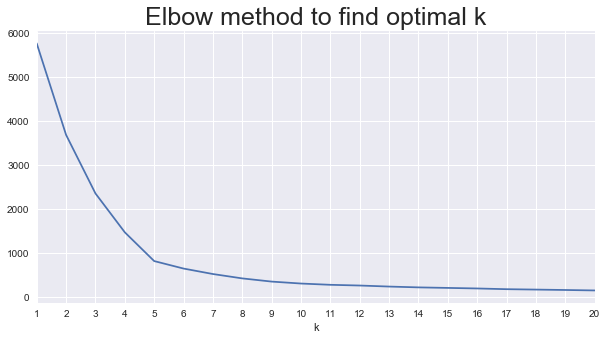

In [43]:
sse_df.set_index(sse_df.k, inplace=True)
ax = sse_df.sse.plot(xticks=sse_df.index, figsize=(10, 5))
_ = ax.set_title('Elbow method to find optimal k', fontsize=25)

In [48]:
op_k = 5
n_init = 20
n_jobs = -1

kmeans = KMeans(n_clusters=op_k, n_init=n_init, n_jobs=n_jobs).fit(empresa_matrix_np)
empresa_matrix_df = pd.DataFrame(data=empresa_matrix_np,
                                 index=[i for i in range(empresa_matrix_np.shape[0])],
                                 columns=[i for i in range(empresa_matrix_np.shape[1])])

# add the assigned classes to result
result = empresa_matrix_df.copy(deep=True)
result['label'] = kmeans.labels_

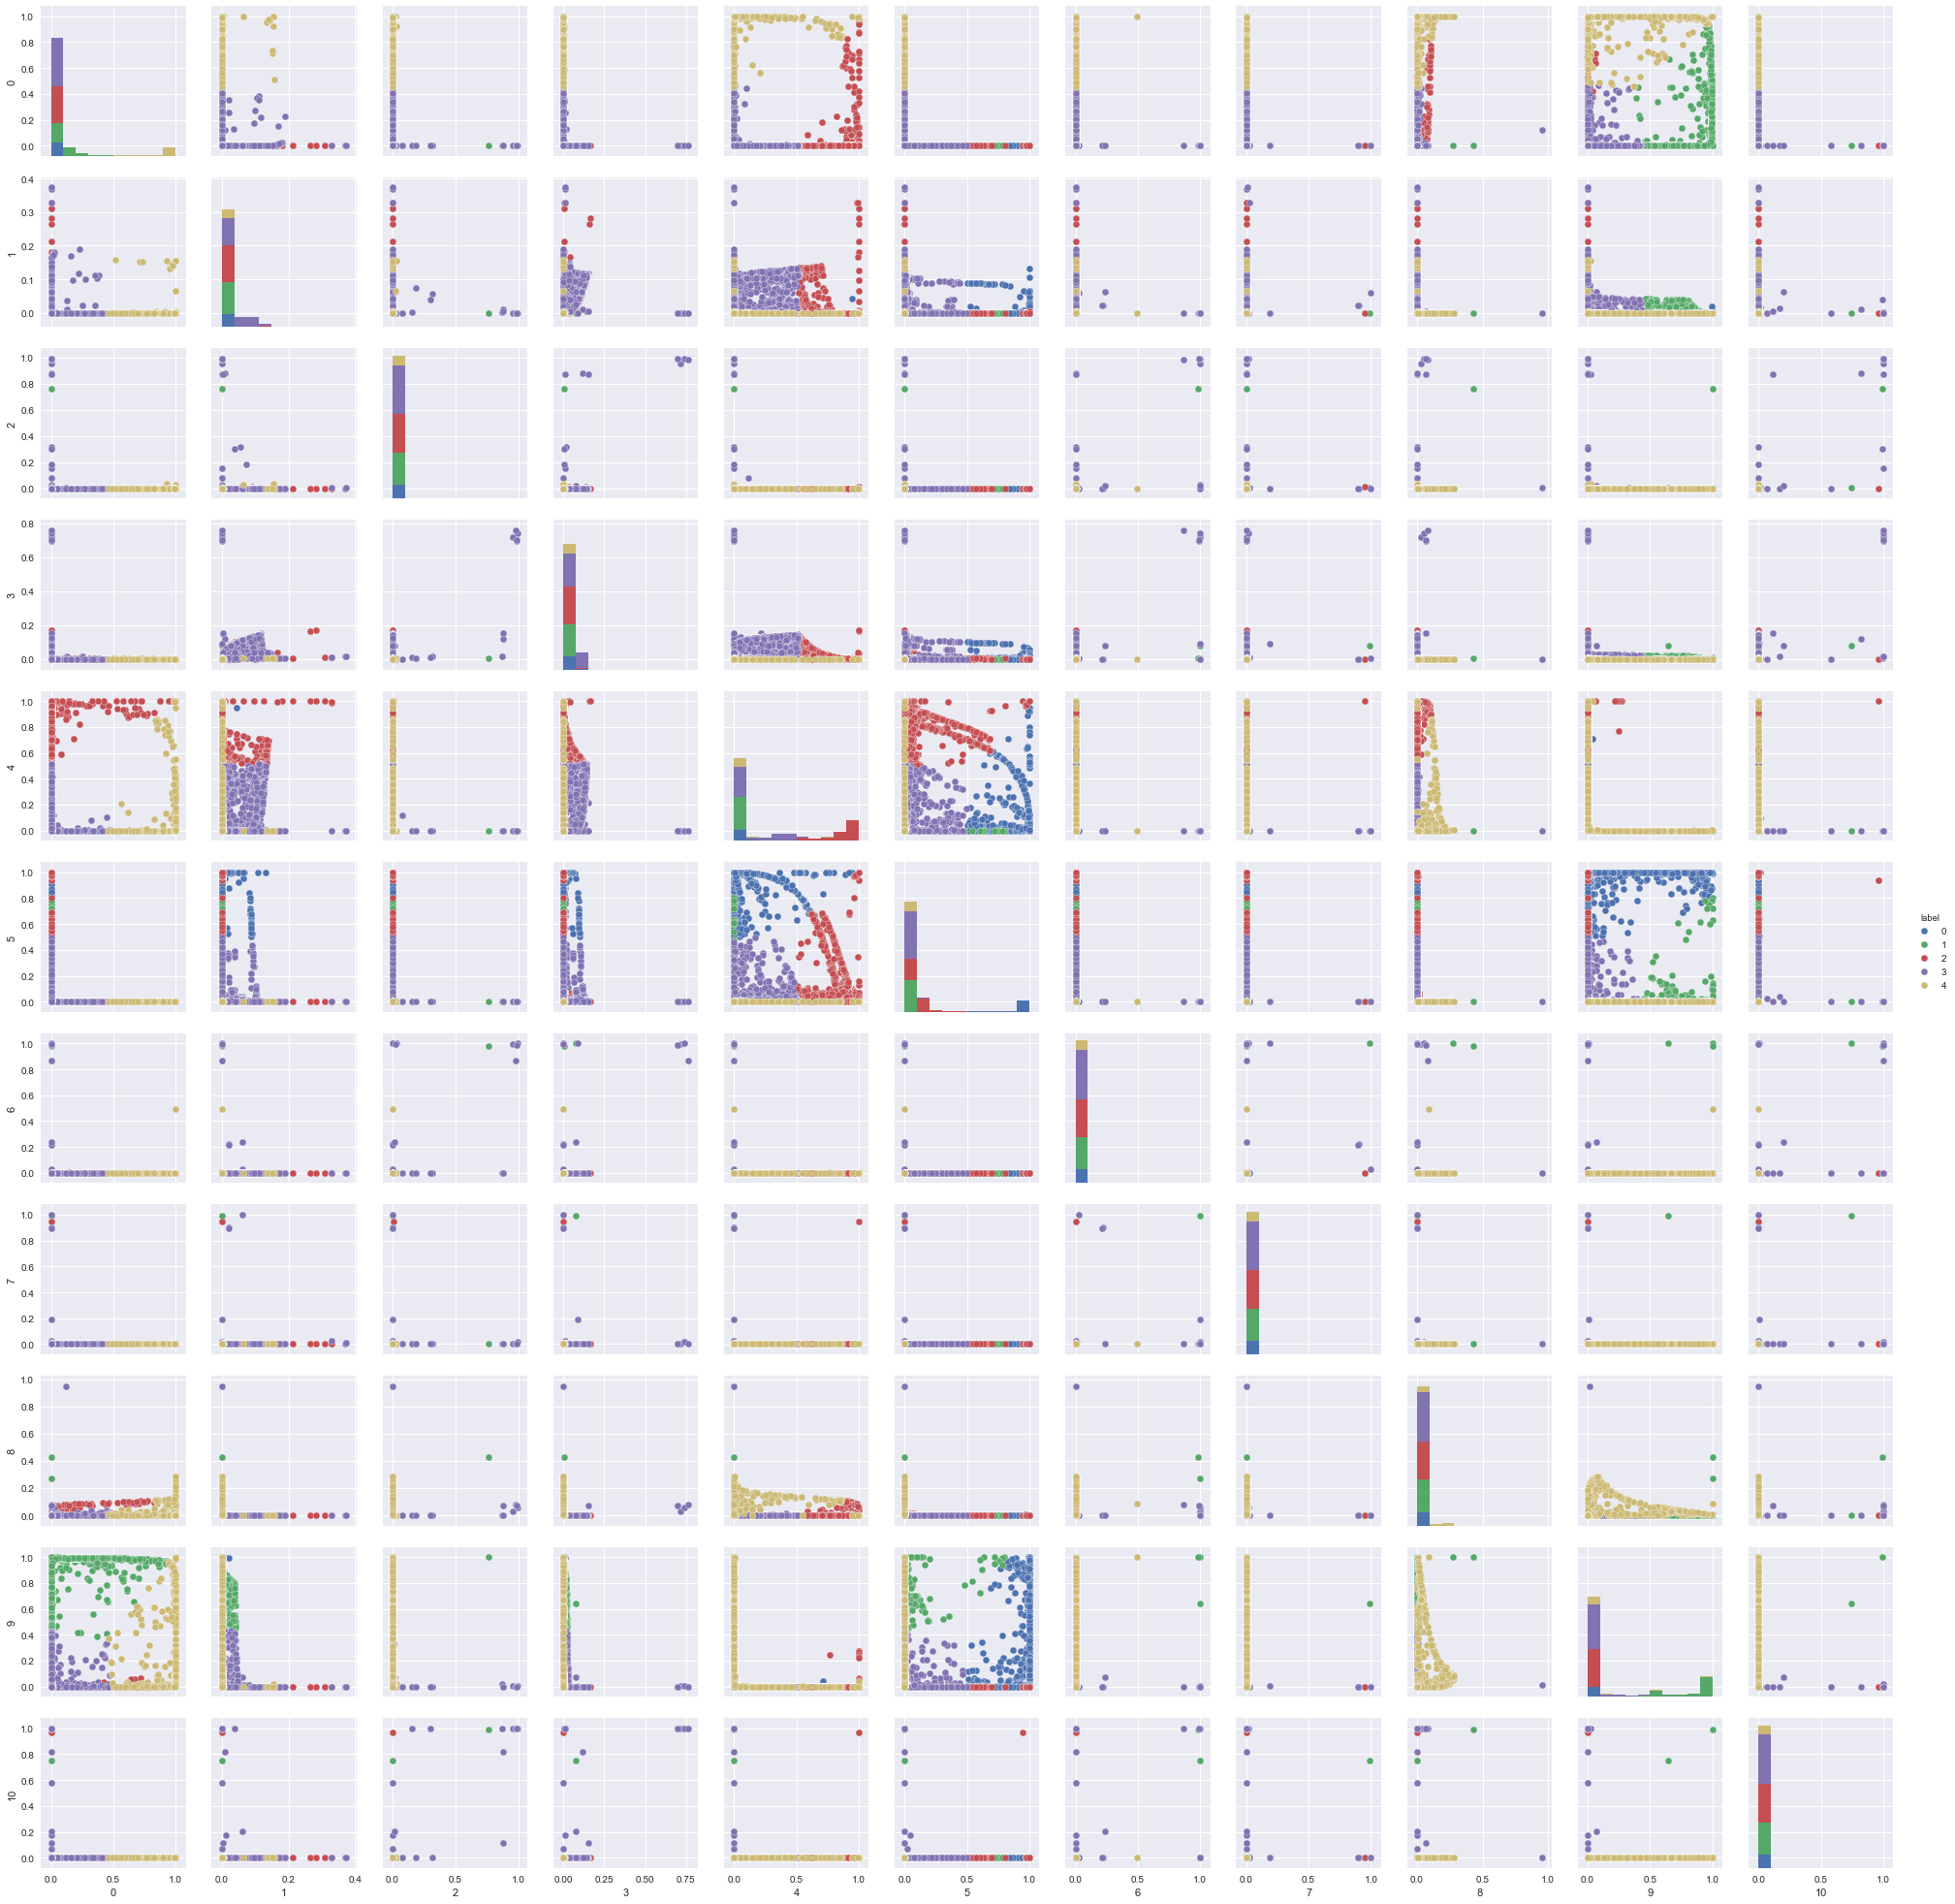

In [49]:
to_plot = [col for col in result.columns if col != 'label']
ax = sns.pairplot(data=result, x_vars=to_plot, y_vars=to_plot, hue='label')

##
Definicion de misma licitacion: Mismo nombre, misma descripcion 

Etender desde las empresas que ganan licitaciones y tratar de hacer una especie de distancias por empresas. (perseverantes podria ser una cosa)